In [3]:
# ============================================
# SETUP
# ============================================
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt # Standard import for plotting
from matplotlib import rcParams # Import rcParams here
from scipy import stats
%matplotlib inline
rcParams['figure.figsize'] = 15, 10

# ============================================
# LOAD ALL CLEANED DATASETS
# ============================================
df_pima = pd.read_csv("new/pima.csv")
df_health = pd.read_csv("new/indicator.csv")
df_global = pd.read_csv("new/world.csv")

print("Pima shape:", df_pima.shape)
print("Health Indicators shape:", df_health.shape)
print("Global shape:", df_global.shape)

Pima shape: (724, 14)
Health Indicators shape: (253680, 20)
Global shape: (203, 6)


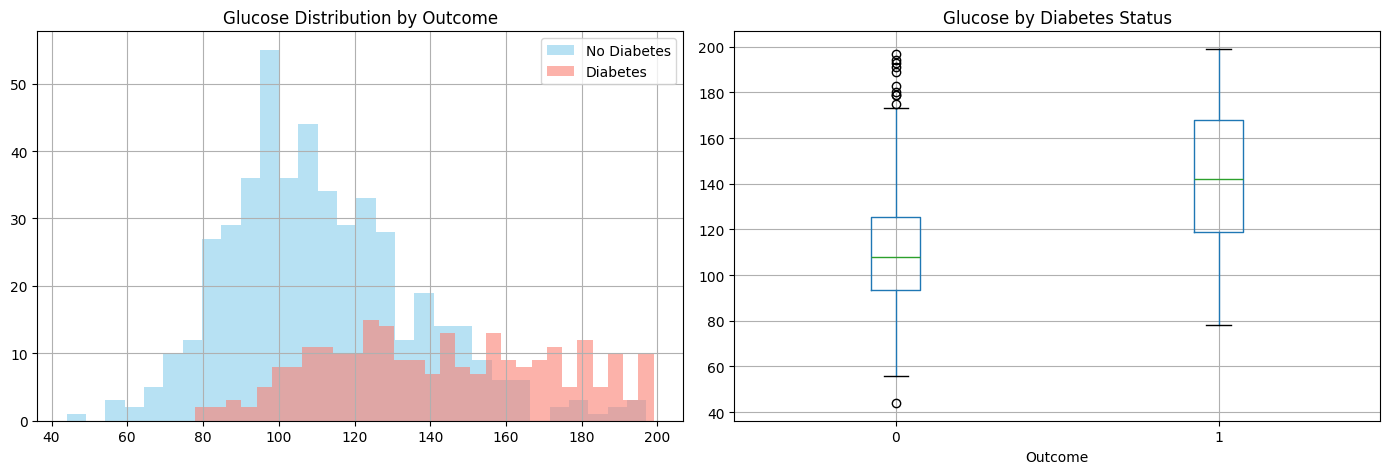

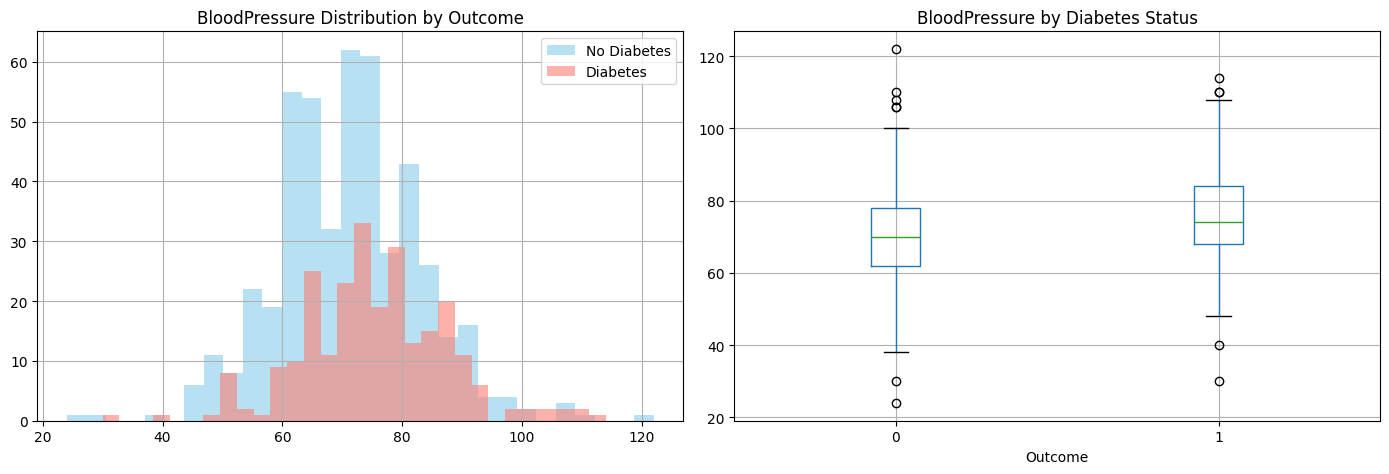

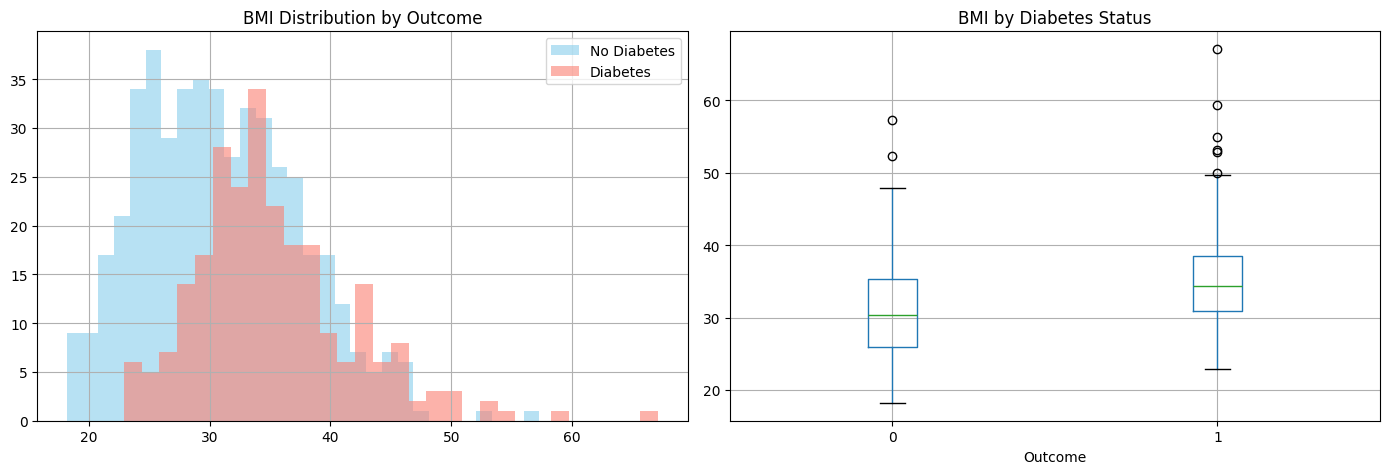

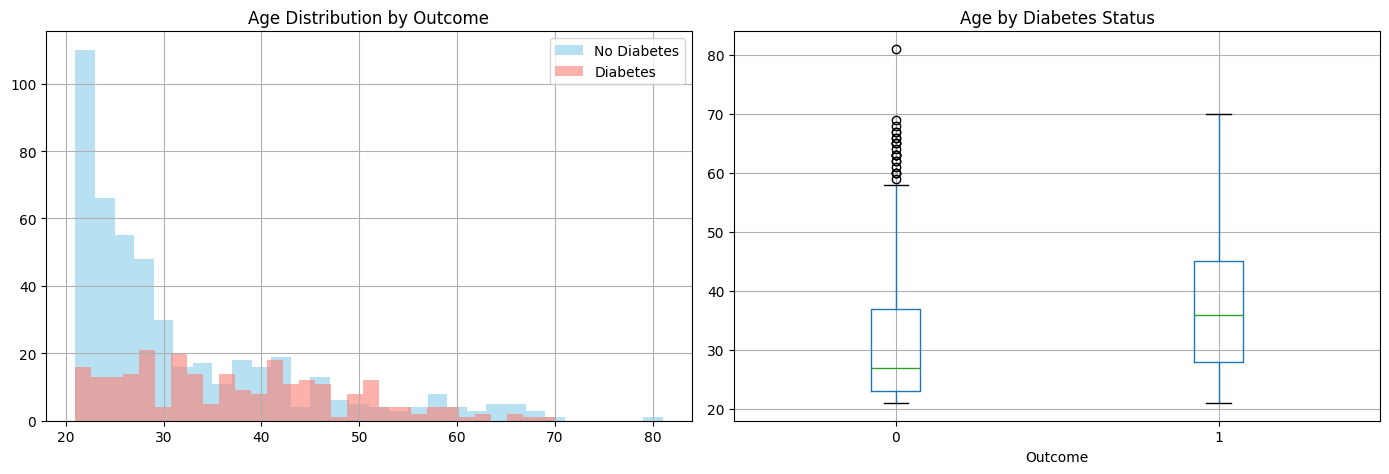

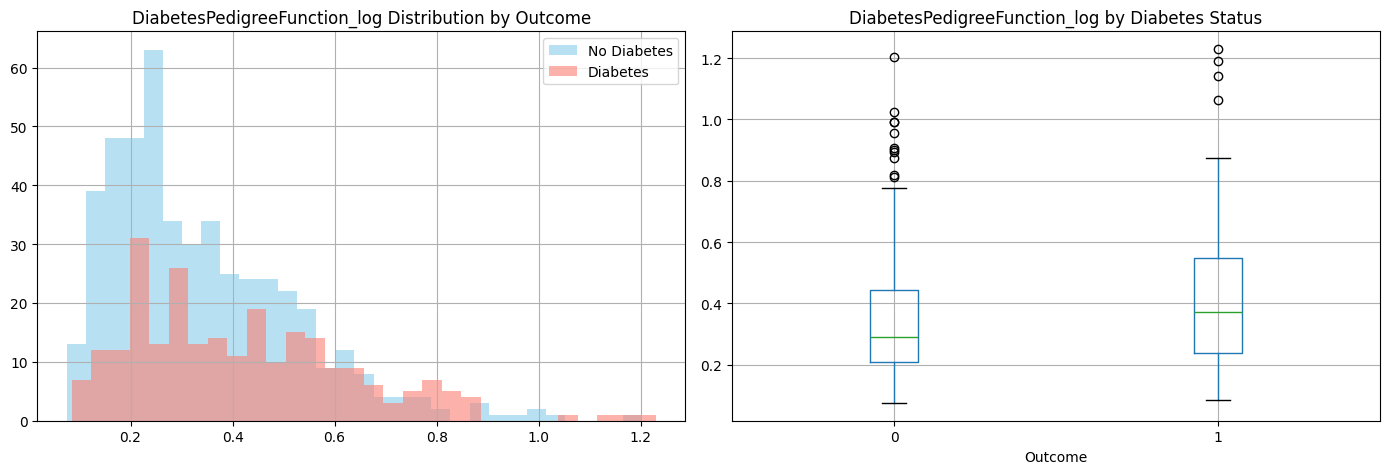

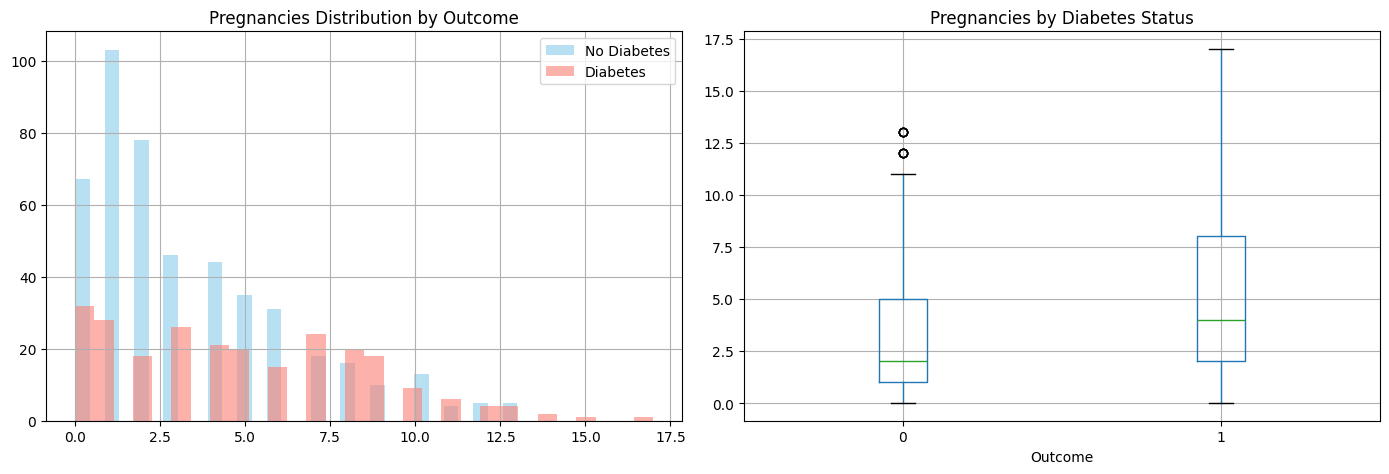

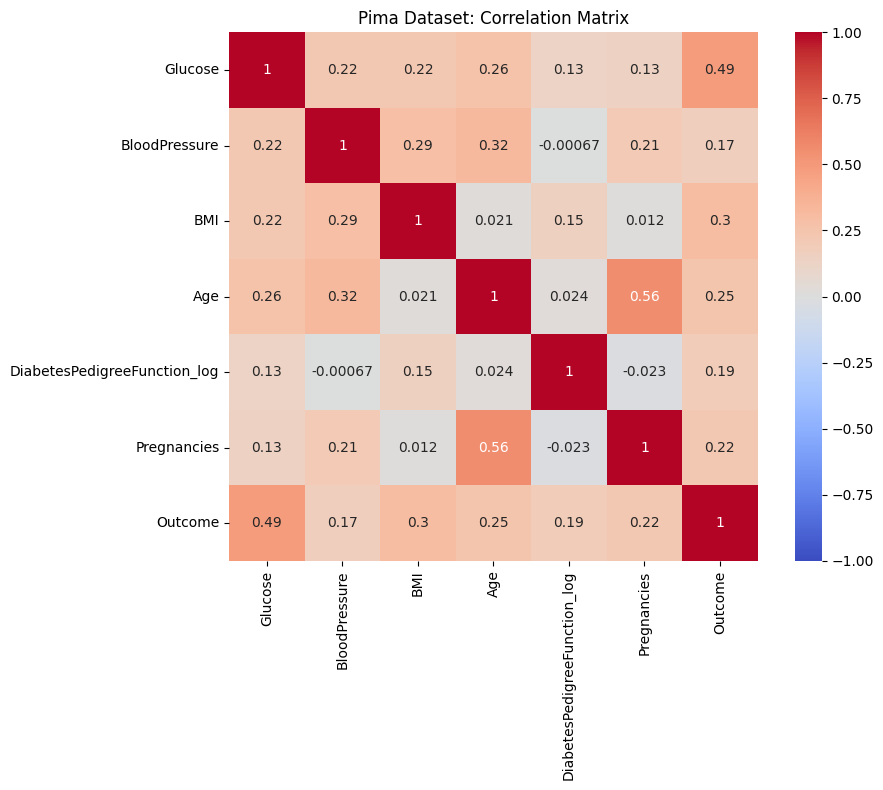


Pima - Effect Sizes (Cohen's d):
                              Effect Size
Glucose                          1.142615
BMI                              0.659331
Age                              0.536181
Pregnancies                      0.468801
DiabetesPedigreeFunction_log     0.395924
BloodPressure                    0.354900


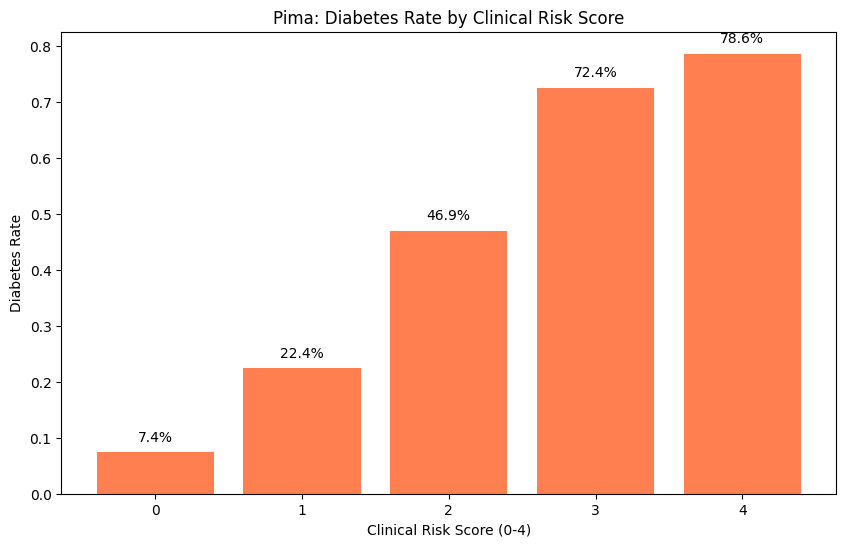

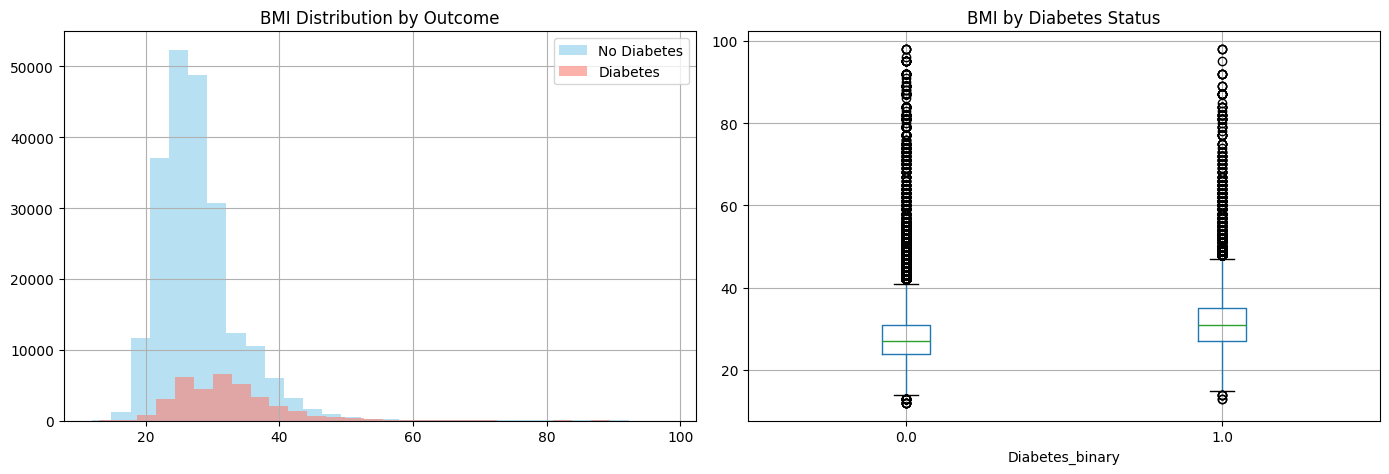

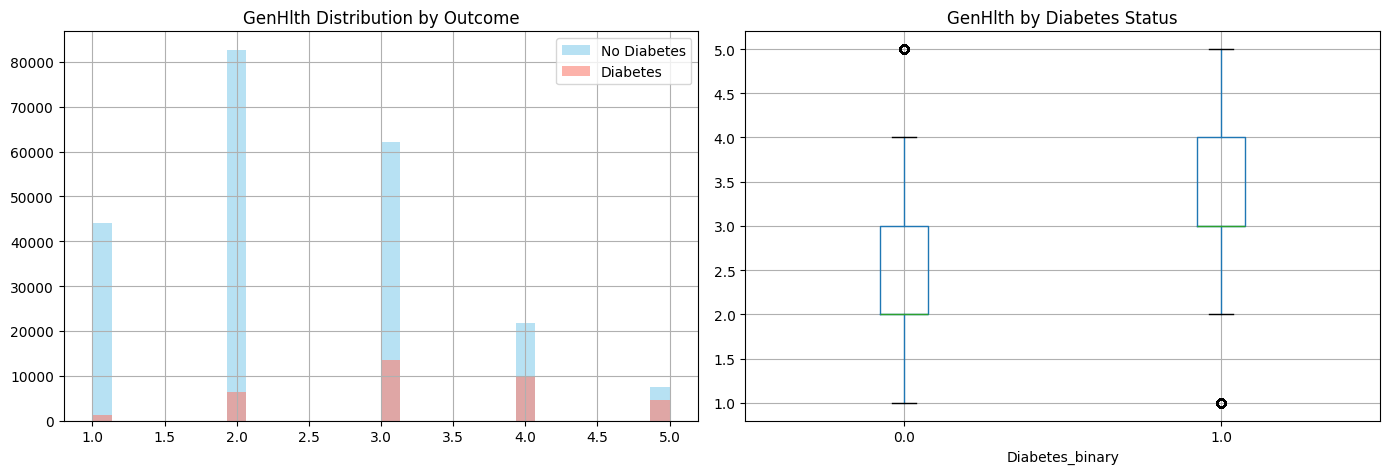

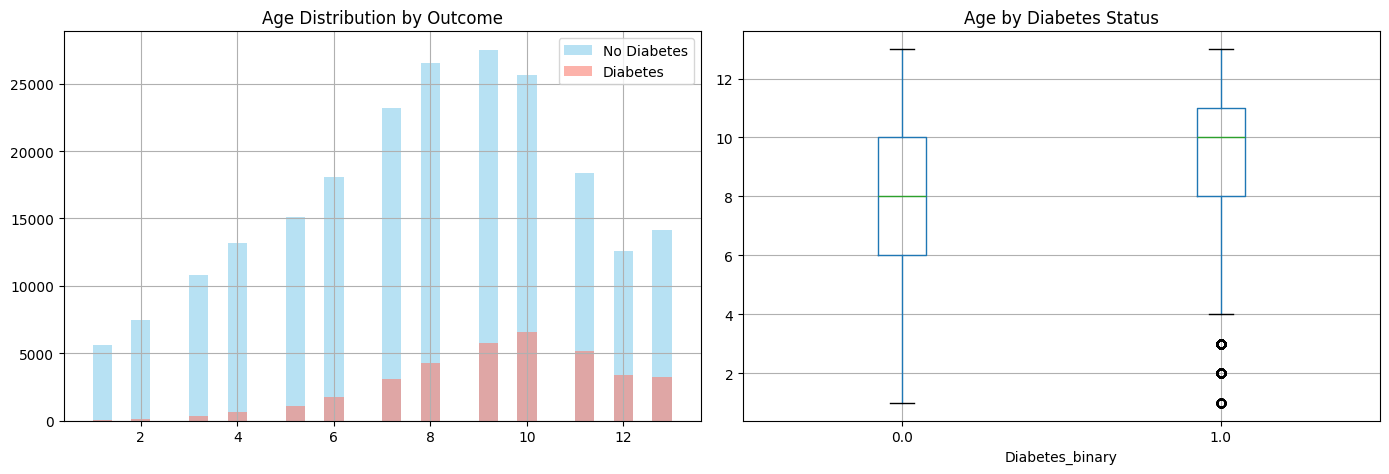

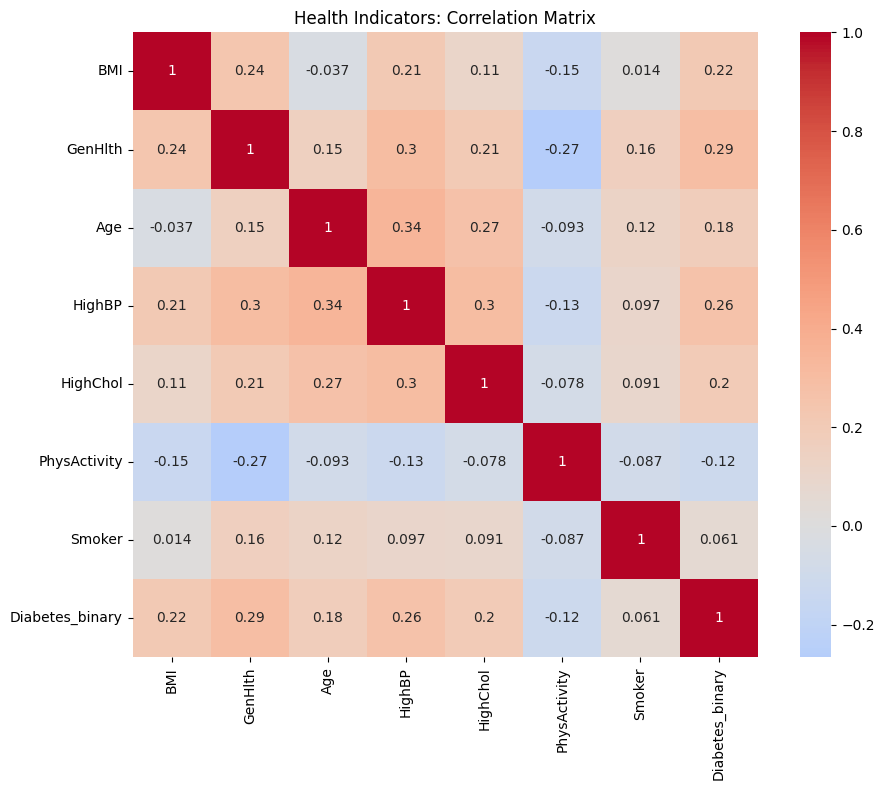

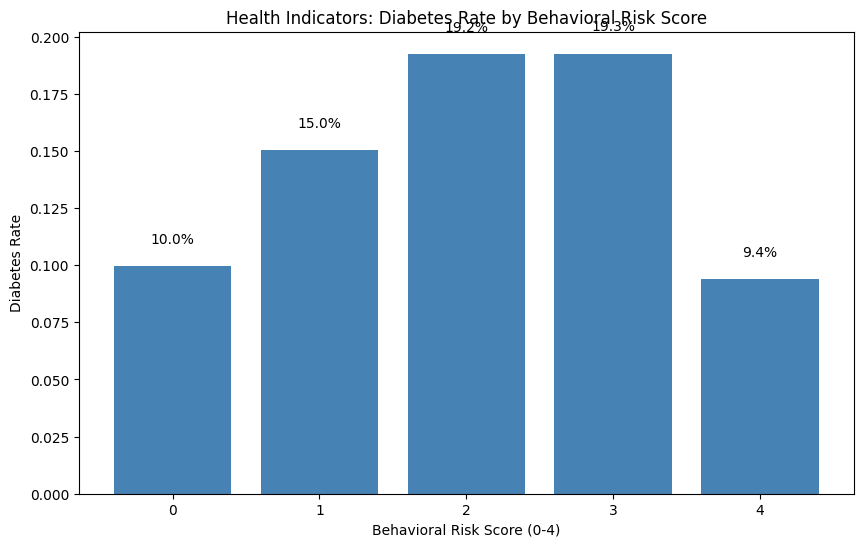

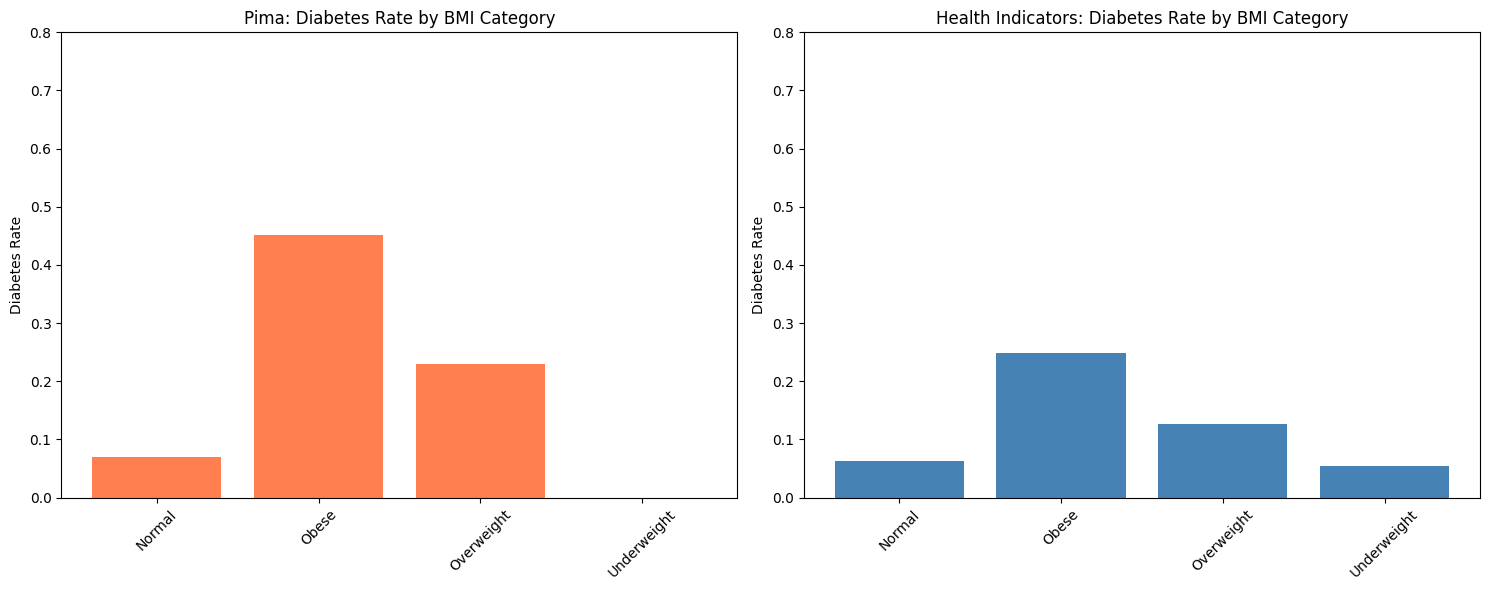

In [5]:
# ============================================
# RQ1: CLINICAL & BEHAVIORAL FACTORS
# ============================================

# --- 1.1 PIMA: Univariate Analysis ---
# Distributions by outcome
continuous_vars = ['Glucose', 'BloodPressure', 'BMI', 'Age', 
                   'DiabetesPedigreeFunction_log', 'Pregnancies']

for var in continuous_vars:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overlapping histograms
    df_pima[df_pima['Outcome']==0][var].hist(ax=axes[0], alpha=0.6, 
                                               label='No Diabetes', bins=30, color='skyblue')
    df_pima[df_pima['Outcome']==1][var].hist(ax=axes[0], alpha=0.6, 
                                               label='Diabetes', bins=30, color='salmon')
    axes[0].set_title(f'{var} Distribution by Outcome')
    axes[0].legend()
    
    # Box plots
    df_pima.boxplot(column=var, by='Outcome', ax=axes[1])
    axes[1].set_title(f'{var} by Diabetes Status')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'Figures/pima_{var}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- 1.2 PIMA: Correlation Analysis ---
# Correlation matrix
corr_matrix = df_pima[continuous_vars + ['Outcome']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True)
plt.title('Pima Dataset: Correlation Matrix')
plt.tight_layout()
plt.savefig('Figures/pima_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Effect sizes (Cohen's d)
effect_sizes_pima = {}
for var in continuous_vars:
    no_diabetes = df_pima[df_pima['Outcome']==0][var]
    diabetes = df_pima[df_pima['Outcome']==1][var]
    
    mean_diff = diabetes.mean() - no_diabetes.mean()
    pooled_std = np.sqrt((no_diabetes.std()**2 + diabetes.std()**2) / 2)
    cohens_d = mean_diff / pooled_std
    effect_sizes_pima[var] = cohens_d

effect_df_pima = pd.DataFrame.from_dict(effect_sizes_pima, orient='index', 
                                         columns=['Effect Size']).sort_values('Effect Size', key=abs, ascending=False)
print("\nPima - Effect Sizes (Cohen's d):")
print(effect_df_pima)

# --- 1.3 PIMA: Clinical Risk Score Analysis ---
risk_score_analysis = df_pima.groupby('Clinical_Risk_Score')['Outcome'].agg(['mean', 'count'])
plt.figure(figsize=(10, 6))
plt.bar(risk_score_analysis.index, risk_score_analysis['mean'], color='coral')
plt.xlabel('Clinical Risk Score (0-4)')
plt.ylabel('Diabetes Rate')
plt.title('Pima: Diabetes Rate by Clinical Risk Score')
for i, v in enumerate(risk_score_analysis['mean']):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center')
plt.savefig('Figures/pima_clinical_risk_score.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 1.4 HEALTH INDICATORS: Univariate Analysis ---
# Key variables for Health Indicators
health_vars = ['BMI', 'GenHlth', 'Age', 'PhysActivity', 'Smoker', 
               'HvyAlcoholConsump', 'HighBP', 'HighChol']

# For continuous: BMI, GenHlth, Age
for var in ['BMI', 'GenHlth', 'Age']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    df_health[df_health['Diabetes_binary']==0][var].hist(ax=axes[0], alpha=0.6, 
                                                           label='No Diabetes', bins=30, color='skyblue')
    df_health[df_health['Diabetes_binary']==1][var].hist(ax=axes[0], alpha=0.6, 
                                                           label='Diabetes', bins=30, color='salmon')
    axes[0].set_title(f'{var} Distribution by Outcome')
    axes[0].legend()
    
    df_health.boxplot(column=var, by='Diabetes_binary', ax=axes[1])
    axes[1].set_title(f'{var} by Diabetes Status')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'Figures/health_{var}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- 1.5 HEALTH INDICATORS: Correlation Analysis ---
corr_matrix_health = df_health[['BMI', 'GenHlth', 'Age', 'HighBP', 'HighChol', 
                                  'PhysActivity', 'Smoker', 'Diabetes_binary']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_health, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Health Indicators: Correlation Matrix')
plt.tight_layout()
plt.savefig('Figures/health_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 1.6 HEALTH INDICATORS: Behavioral Risk Score ---
behavioral_risk = df_health.groupby('Behavioral_Risk_Score')['Diabetes_binary'].agg(['mean', 'count'])
plt.figure(figsize=(10, 6))
plt.bar(behavioral_risk.index, behavioral_risk['mean'], color='steelblue')
plt.xlabel('Behavioral Risk Score (0-4)')
plt.ylabel('Diabetes Rate')
plt.title('Health Indicators: Diabetes Rate by Behavioral Risk Score')
for i, v in enumerate(behavioral_risk['mean']):
    plt.text(i, v + 0.01, f'{v:.1%}', ha='center')
plt.savefig('Figures/health_behavioral_risk_score.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 1.7 CROSS-DATASET VALIDATION: BMI ---
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pima
pima_bmi = df_pima.groupby('BMI_Category')['Outcome'].mean()
axes[0].bar(range(len(pima_bmi)), pima_bmi.values, color='coral')
axes[0].set_xticks(range(len(pima_bmi)))
axes[0].set_xticklabels(pima_bmi.index, rotation=45)
axes[0].set_ylabel('Diabetes Rate')
axes[0].set_title('Pima: Diabetes Rate by BMI Category')
axes[0].set_ylim(0, 0.8)

# Health Indicators
health_bmi = df_health.groupby('BMI_Category')['Diabetes_binary'].mean()
axes[1].bar(range(len(health_bmi)), health_bmi.values, color='steelblue')
axes[1].set_xticks(range(len(health_bmi)))
axes[1].set_xticklabels(health_bmi.index, rotation=45)
axes[1].set_ylabel('Diabetes Rate')
axes[1].set_title('Health Indicators: Diabetes Rate by BMI Category')
axes[1].set_ylim(0, 0.8)

plt.tight_layout()
plt.savefig('Figures/cross_dataset_bmi_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 1.8 CROSS-DATASET VALIDATION: Age ---
# Similar side-by-side for Age...

# --- 1.9 Summary Table: Effect Sizes Comparison ---
# Create a comparison table of shared variables

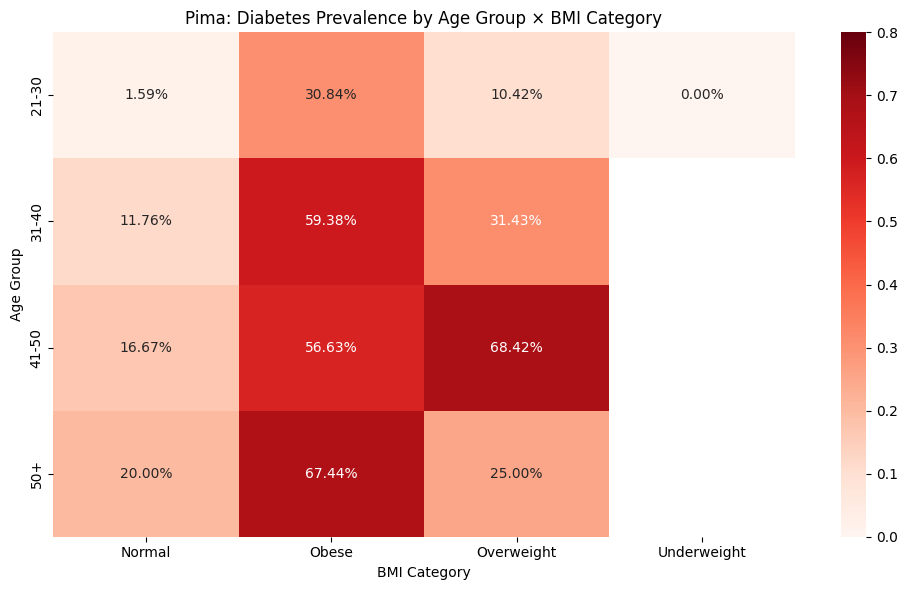

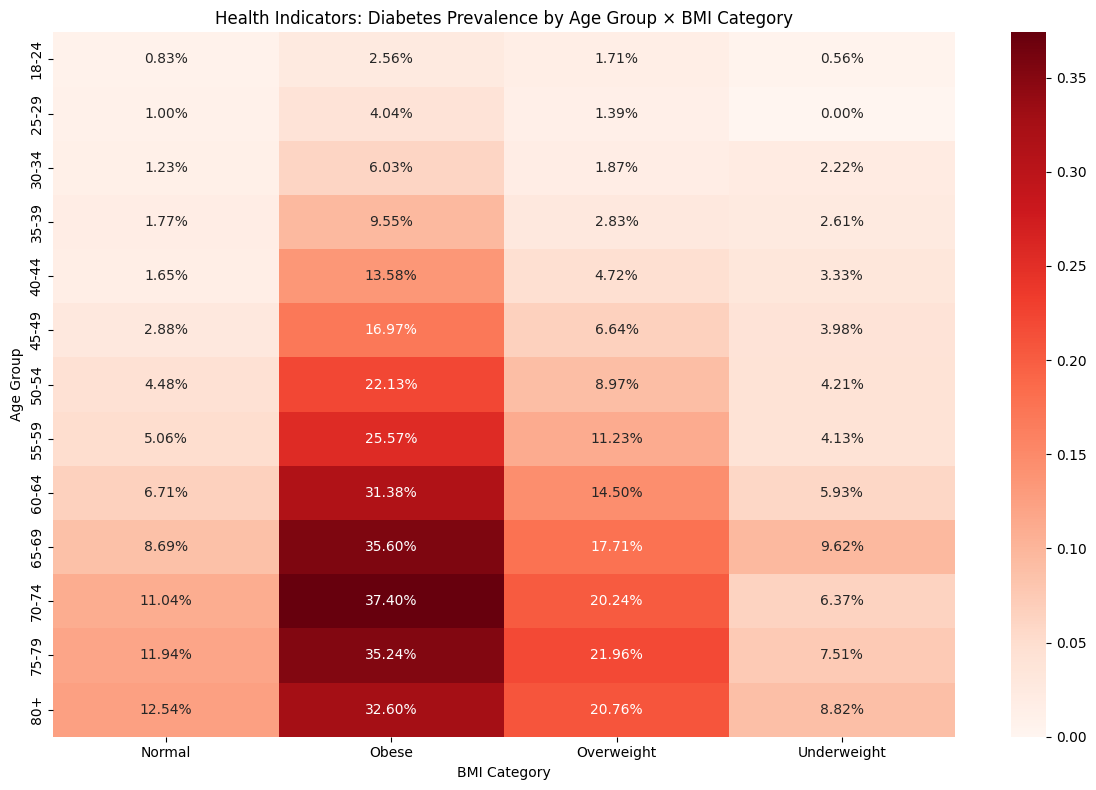

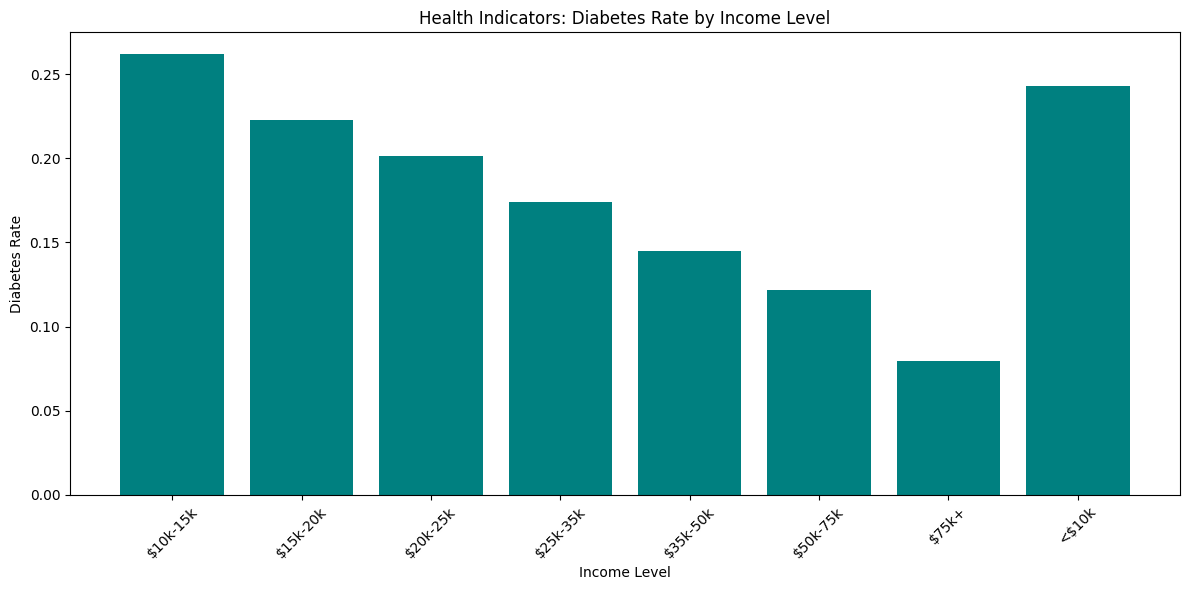

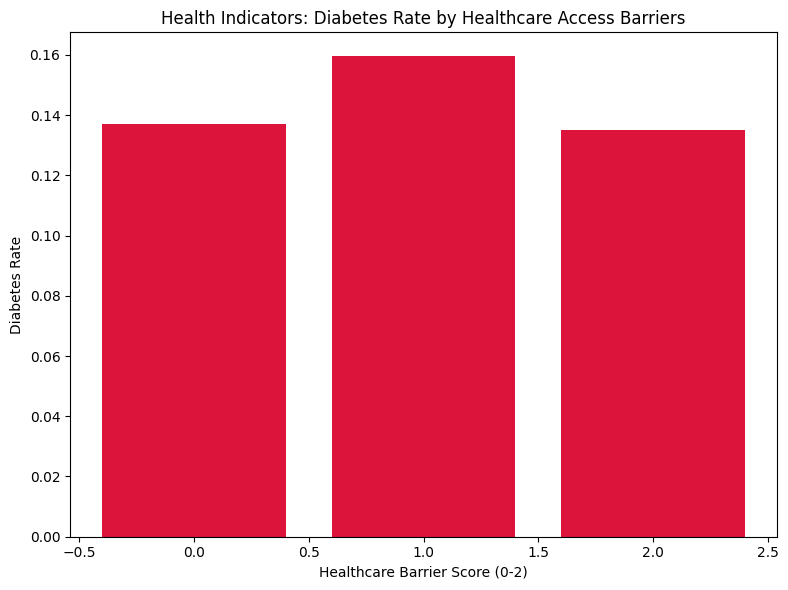


Top 10 Highest-Risk Subgroups:
                                         mean  count
Age_Group BMI_Category Income_Level                 
70-74     Obese        <$10k         0.506383    235
65-69     Obese        $10k-15k      0.483926    591
60-64     Obese        <$10k         0.480315    508
65-69     Obese        <$10k         0.479885    348
75-79     Obese        <$10k         0.472727    165
60-64     Obese        $10k-15k      0.446055    621
70-74     Obese        $10k-15k      0.443255    467
65-69     Obese        $15k-20k      0.442623    732
75-79     Obese        $10k-15k      0.438650    326
70-74     Obese        $15k-20k      0.438596    570


In [6]:
# ============================================
# RQ2: POPULATION SEGMENTS & DISPARITIES
# ============================================

# --- 2.1 PIMA: Age × BMI Heatmap ---
pivot_pima = df_pima.pivot_table(
    values='Outcome',
    index='Age_Group',
    columns='BMI_Category',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_pima, annot=True, fmt='.2%', cmap='Reds', vmin=0, vmax=0.8)
plt.title('Pima: Diabetes Prevalence by Age Group × BMI Category')
plt.ylabel('Age Group')
plt.xlabel('BMI Category')
plt.tight_layout()
plt.savefig('Figures/pima_age_bmi_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 2.2 HEALTH INDICATORS: Age × BMI Heatmap ---
pivot_health = df_health.pivot_table(
    values='Diabetes_binary',
    index='Age_Group',
    columns='BMI_Category',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_health, annot=True, fmt='.2%', cmap='Reds')
plt.title('Health Indicators: Diabetes Prevalence by Age Group × BMI Category')
plt.ylabel('Age Group')
plt.xlabel('BMI Category')
plt.tight_layout()
plt.savefig('Figures/health_age_bmi_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 2.3 HEALTH INDICATORS: Income Disparities ---
income_analysis = df_health.groupby('Income_Level')['Diabetes_binary'].agg(['mean', 'count'])
plt.figure(figsize=(12, 6))
plt.bar(range(len(income_analysis)), income_analysis['mean'], color='teal')
plt.xticks(range(len(income_analysis)), income_analysis.index, rotation=45)
plt.ylabel('Diabetes Rate')
plt.xlabel('Income Level')
plt.title('Health Indicators: Diabetes Rate by Income Level')
plt.tight_layout()
plt.savefig('Figures/health_income_disparity.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 2.4 HEALTH INDICATORS: Healthcare Barriers ---
barrier_analysis = df_health.groupby('Healthcare_Barrier')['Diabetes_binary'].agg(['mean', 'count'])
plt.figure(figsize=(8, 6))
plt.bar(barrier_analysis.index, barrier_analysis['mean'], color='crimson')
plt.xlabel('Healthcare Barrier Score (0-2)')
plt.ylabel('Diabetes Rate')
plt.title('Health Indicators: Diabetes Rate by Healthcare Access Barriers')
plt.tight_layout()
plt.savefig('Figures/health_healthcare_barriers.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 2.5 High-Risk Subgroup Identification ---
high_risk = df_health.groupby(['Age_Group', 'BMI_Category', 'Income_Level'])['Diabetes_binary'].agg(['mean', 'count'])
high_risk = high_risk[high_risk['count'] >= 100]  # Minimum sample size
high_risk = high_risk.sort_values('mean', ascending=False).head(10)
print("\nTop 10 Highest-Risk Subgroups:")
print(high_risk)

U.S. Diabetes Prevalence:
           Entity Code  2011  2024  Prevalence_Change  Percent_Change
44  United States  USA   9.4  13.7                4.3       45.744681

2011: 9.4%
2024: 13.7%
Absolute Change: 4.299999999999999 percentage points
Percent Change: 45.7%


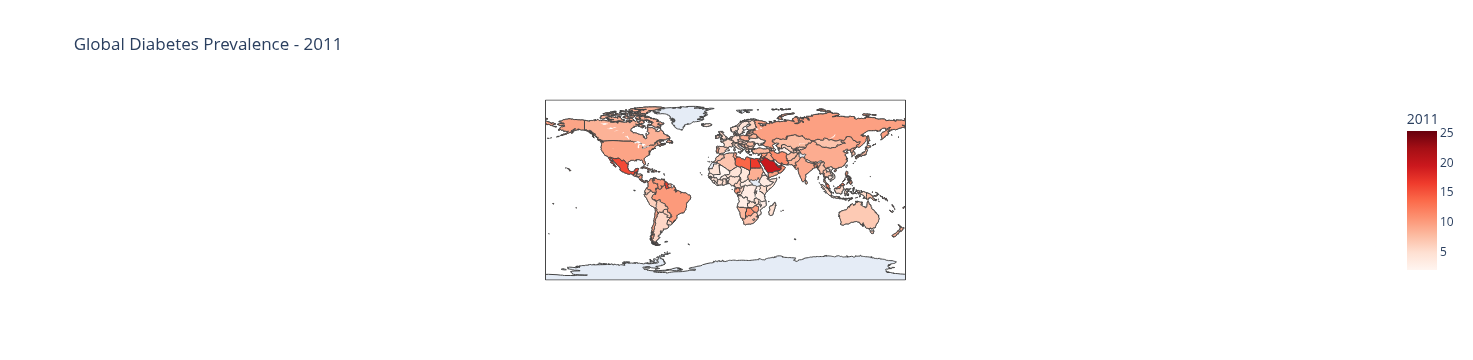

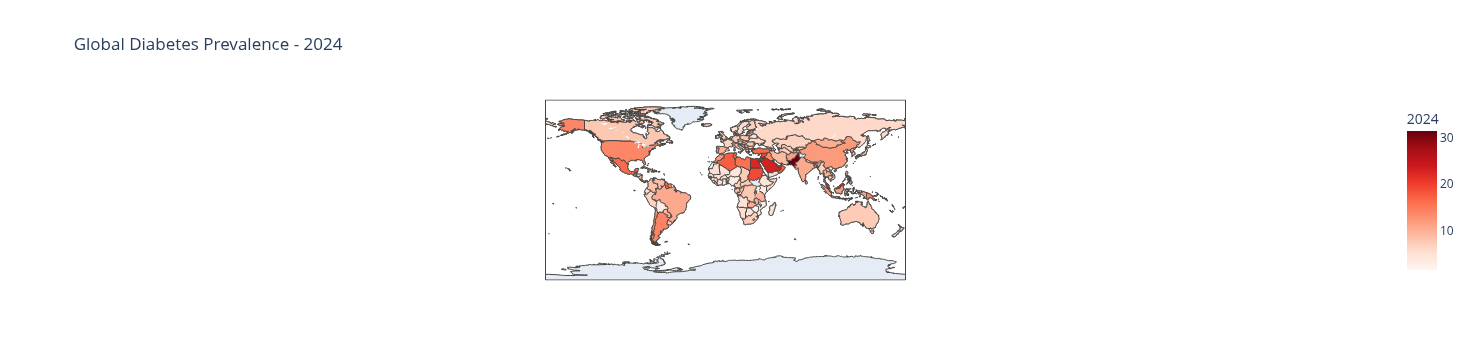

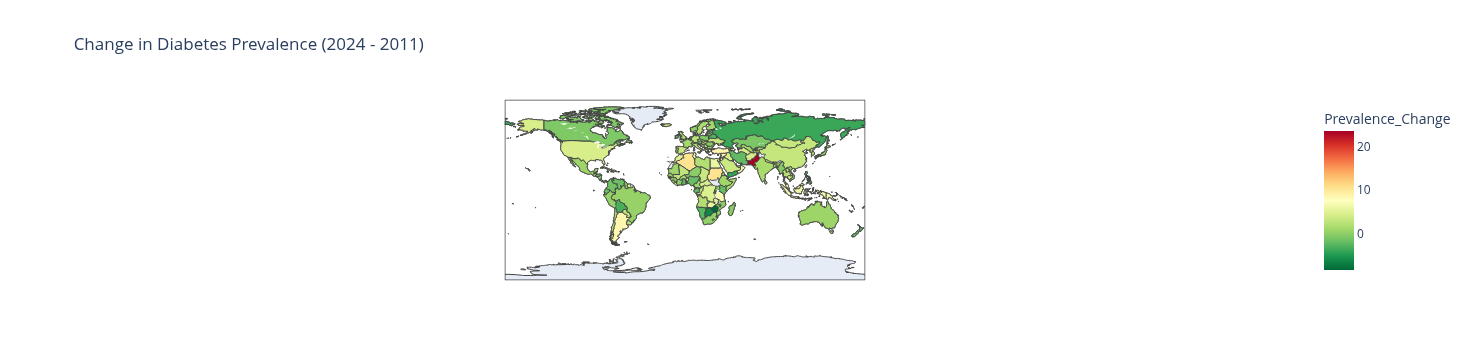

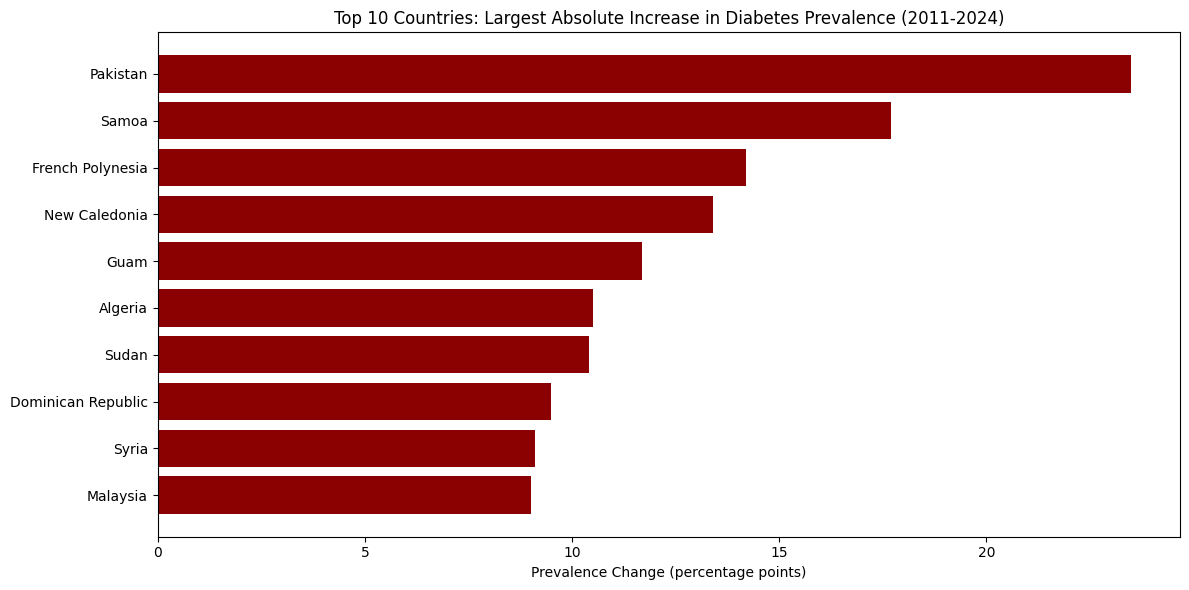

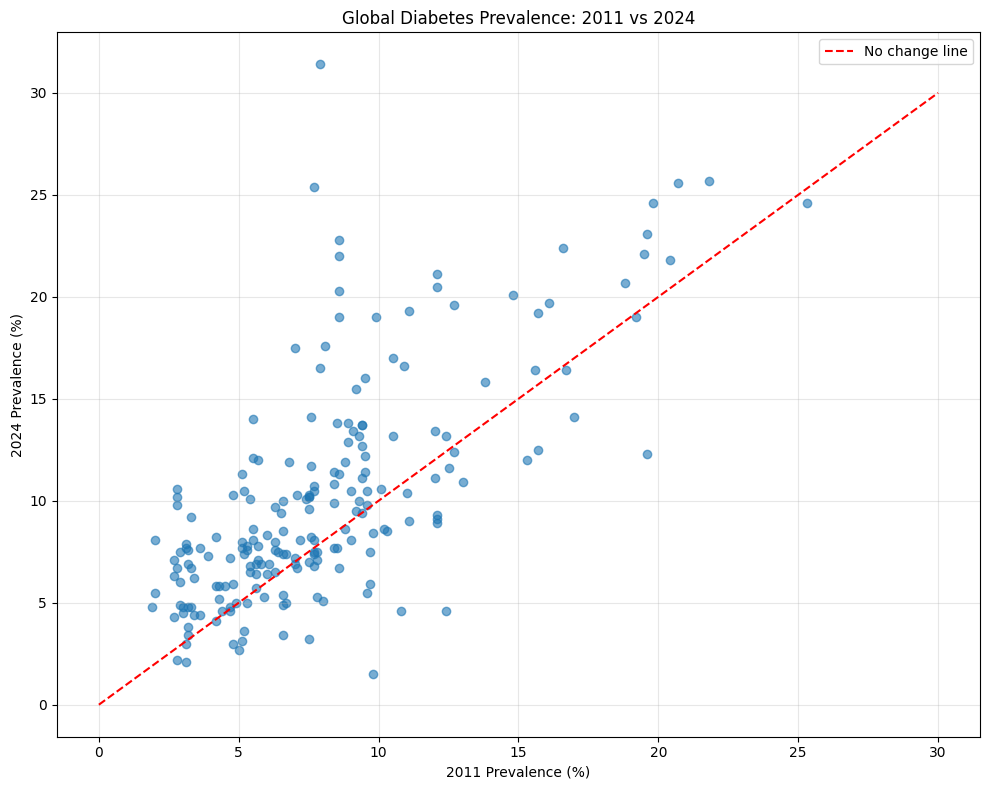

In [8]:
# ============================================
# RQ3: INDIVIDUAL TO POPULATION PATTERNS
# ============================================

# --- 3.1 U.S. Prevalence Extraction ---
us_data = df_global[df_global['Entity'] == 'United States']
print("U.S. Diabetes Prevalence:")
print(us_data)

us_2011 = us_data['2011'].values[0]
us_2024 = us_data['2024'].values[0]
us_change = us_data['Prevalence_Change'].values[0]
us_pct_change = us_data['Percent_Change'].values[0]

print(f"\n2011: {us_2011}%")
print(f"2024: {us_2024}%")
print(f"Absolute Change: {us_change} percentage points")
print(f"Percent Change: {us_pct_change:.1f}%")

# --- 3.2 Global Choropleth Maps ---
# 2011 Prevalence
fig = px.choropleth(df_global,
                    locations='Code',
                    color='2011',
                    hover_name='Entity',
                    title='Global Diabetes Prevalence - 2011',
                    color_continuous_scale='Reds')
fig.write_html('Figures/global_map_2011.html')
fig.show()

# 2024 Prevalence
fig = px.choropleth(df_global,
                    locations='Code',
                    color='2024',
                    hover_name='Entity',
                    title='Global Diabetes Prevalence - 2024',
                    color_continuous_scale='Reds')
fig.write_html('Figures/global_map_2024.html')
fig.show()

# Prevalence Change
fig = px.choropleth(df_global,
                    locations='Code',
                    color='Prevalence_Change',
                    hover_name='Entity',
                    title='Change in Diabetes Prevalence (2024 - 2011)',
                    color_continuous_scale='RdYlGn_r')
fig.write_html('Figures/global_map_change.html')
fig.show()

# --- 3.3 Top Countries with Largest Increases ---
top_10_absolute = df_global.nlargest(10, 'Prevalence_Change')
plt.figure(figsize=(12, 6))
plt.barh(top_10_absolute['Entity'], top_10_absolute['Prevalence_Change'], color='darkred')
plt.xlabel('Prevalence Change (percentage points)')
plt.title('Top 10 Countries: Largest Absolute Increase in Diabetes Prevalence (2011-2024)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Figures/global_top10_absolute_increase.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 3.4 Scatter Plot: 2011 vs 2024 ---
plt.figure(figsize=(10, 8))
plt.scatter(df_global['2011'], df_global['2024'], alpha=0.6)
plt.plot([0, 30], [0, 30], 'r--', label='No change line')
plt.xlabel('2011 Prevalence (%)')
plt.ylabel('2024 Prevalence (%)')
plt.title('Global Diabetes Prevalence: 2011 vs 2024')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('Figures/global_scatter_2011_vs_2024.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# ============================================
# KEY STATISTICS FOR REPORT WRITING
# ============================================

print("=== RQ1: CLINICAL VS BEHAVIORAL FACTORS ===")
print("\nPima - Top 3 Correlations:")
pima_corr = df_pima[['Glucose', 'BMI', 'Age', 'BloodPressure', 'Outcome']].corr()['Outcome'].sort_values(ascending=False)
print(pima_corr.head(4))  # Top 3 + Outcome itself

print("\nHealth - Top 3 Correlations:")
health_corr = df_health[['BMI', 'HighBP', 'HighChol', 'GenHlth', 'Age', 'Diabetes_binary']].corr()['Diabetes_binary'].sort_values(ascending=False)
print(health_corr.head(4))

print("\nClinical Risk Score Impact (Pima):")
print(df_pima.groupby('Clinical_Risk_Score')['Outcome'].mean())

print("\nBehavioral Risk Score Impact (Health):")
print(df_health.groupby('Behavioral_Risk_Score')['Diabetes_binary'].mean())

print("\n=== RQ2: POPULATION SEGMENTS ===")
print("\nHighest-risk Age×BMI combination (Pima):")
pivot_pima = df_pima.pivot_table(values='Outcome', index='Age_Group', columns='BMI_Category', aggfunc='mean')
print(pivot_pima.max().max(), "at", pivot_pima.stack().idxmax())

print("\nIncome disparity (Health Indicators):")
# income_rates = df_health.groupby('Income_Level')['Diabetes_binary'].mean()
# print(f"Lowest income: {income_rates.iloc[0]:.2%}")
# print(f"Highest income: {income_rates.iloc[-1]:.2%}")
# print(f"Disparity ratio: {income_rates.iloc[0] / income_rates.iloc[-1]:.2f}x")

# Get rates by income level
income_rates = df_health.groupby('Income_Level')['Diabetes_binary'].mean().sort_index()
print(income_rates)  # See all 8 categories

# Identify highest and lowest diabetes rates
max_rate = income_rates.max()  # Should be ~0.265 ($10k-15k)
min_rate = income_rates.min()  # Should be ~0.080 ($75k+)

print(f"\nHighest diabetes rate: {max_rate:.3%} at {income_rates.idxmax()}")
print(f"Lowest diabetes rate: {min_rate:.3%} at {income_rates.idxmin()}")
print(f"Disparity ratio: {max_rate/min_rate:.2f}x")

print("\n=== RQ3: INDIVIDUAL TO POPULATION ===")
us_data = df_global[df_global['Entity'] == 'United States'].iloc[0]
print(f"\nU.S. Prevalence 2011: {us_data['2011']:.1f}%")
print(f"U.S. Prevalence 2024: {us_data['2024']:.1f}%")
print(f"Absolute change: {us_data['Prevalence_Change']:.1f} percentage points")
print(f"Relative change: {us_data['Percent_Change']:.1f}%")

print("\nGlobal average change:")
print(f"Mean prevalence change: {df_global['Prevalence_Change'].mean():.2f} pp")
print(f"Median prevalence change: {df_global['Prevalence_Change'].median():.2f} pp")

print("\nTop 3 countries with largest increases:")
print(df_global.nlargest(3, 'Prevalence_Change')[['Entity', 'Prevalence_Change']])

=== RQ1: CLINICAL VS BEHAVIORAL FACTORS ===

Pima - Top 3 Correlations:
Outcome    1.000000
Glucose    0.488384
BMI        0.299375
Age        0.245741
Name: Outcome, dtype: float64

Health - Top 3 Correlations:
Diabetes_binary    1.000000
GenHlth            0.293569
HighBP             0.263129
BMI                0.216843
Name: Diabetes_binary, dtype: float64

Clinical Risk Score Impact (Pima):
Clinical_Risk_Score
0    0.073826
1    0.224000
2    0.469484
3    0.724490
4    0.785714
Name: Outcome, dtype: float64

Behavioral Risk Score Impact (Health):
Behavioral_Risk_Score
0    0.099640
1    0.150464
2    0.192400
3    0.192578
4    0.094070
Name: Diabetes_binary, dtype: float64

=== RQ2: POPULATION SEGMENTS ===

Highest-risk Age×BMI combination (Pima):
0.6842105263157895 at ('41-50', 'Overweight')

Income disparity (Health Indicators):
Income_Level
$10k-15k    0.261903
$15k-20k    0.223084
$20k-25k    0.201341
$25k-35k    0.174014
$35k-50k    0.145078
$50k-75k    0.121821
$75k+       

In [10]:
# Missing correlations for Pima
pima_corr_full = df_pima[['Glucose', 'BMI', 'Age', 'BloodPressure', 
                           'DiabetesPedigreeFunction_log', 'Pregnancies', 
                           'Outcome']].corr()['Outcome']
print(pima_corr_full)

# Missing correlations for Health  
health_corr_full = df_health[['BMI', 'GenHlth', 'HighBP', 'HighChol', 
                                'Age', 'PhysActivity', 'Diabetes_binary']].corr()['Diabetes_binary']
print(health_corr_full)

# Health Indicators survey diabetes rate
survey_rate = df_health['Diabetes_binary'].mean()
print(f"BRFSS 2015 Diabetes Rate: {survey_rate:.2%}")

# Obesity prevalence in Health Indicators
obesity_rate = (df_health['BMI'] >= 30).mean()
print(f"Obesity rate: {obesity_rate:.1%}")

# Inactivity rate
inactivity_rate = (df_health['PhysActivity'] == 0).mean()
print(f"Physical inactivity: {inactivity_rate:.1%}")

# Behavioral Risk Score >= 2
high_behavioral_risk = (df_health['Behavioral_Risk_Score'] >= 2).mean()
print(f"Behavioral Risk Score >= 2: {high_behavioral_risk:.1%}")

# Pakistan 2011 and 2024 values for table
pakistan = df_global[df_global['Entity'] == 'Pakistan']
print("\nPakistan:")
print(pakistan[['Entity', '2011', '2024', 'Prevalence_Change']])

# Same for Samoa and French Polynesia
samoa = df_global[df_global['Entity'] == 'Samoa']
fp = df_global[df_global['Entity'] == 'French Polynesia']
print("\nSamoa:", samoa[['2011', '2024']].values)
print("French Polynesia:", fp[['2011', '2024']].values)

Glucose                         0.488384
BMI                             0.299375
Age                             0.245741
BloodPressure                   0.166703
DiabetesPedigreeFunction_log    0.190024
Pregnancies                     0.224417
Outcome                         1.000000
Name: Outcome, dtype: float64
BMI                0.216843
GenHlth            0.293569
HighBP             0.263129
HighChol           0.200276
Age                0.177442
PhysActivity      -0.118133
Diabetes_binary    1.000000
Name: Diabetes_binary, dtype: float64
BRFSS 2015 Diabetes Rate: 13.93%
Obesity rate: 34.6%
Physical inactivity: 24.3%
Behavioral Risk Score >= 2: 20.9%

Pakistan:
     Entity  2011  2024  Prevalence_Change
0  Pakistan   7.9  31.4               23.5

Samoa: [[ 7.7 25.4]]
French Polynesia: [[ 8.6 22.8]]


In [12]:
# Generate the actual table mentioned in the report
high_risk = df_health.groupby(['Age_Group', 'BMI_Category', 'Income_Level'])['Diabetes_binary'].agg(['mean', 'count'])
high_risk = high_risk[high_risk['count'] >= 100]  
high_risk = high_risk.sort_values('mean', ascending=False).head(10)
# print("\nTop 10 High-Risk Subgroups (for Table in Section 3):")
print("\nTop 10 High-Risk Subgroups:")
print(high_risk.reset_index())


Top 10 High-Risk Subgroups:
  Age_Group BMI_Category Income_Level      mean  count
0     70-74        Obese        <$10k  0.506383    235
1     65-69        Obese     $10k-15k  0.483926    591
2     60-64        Obese        <$10k  0.480315    508
3     65-69        Obese        <$10k  0.479885    348
4     75-79        Obese        <$10k  0.472727    165
5     60-64        Obese     $10k-15k  0.446055    621
6     70-74        Obese     $10k-15k  0.443255    467
7     65-69        Obese     $15k-20k  0.442623    732
8     75-79        Obese     $10k-15k  0.438650    326
9     70-74        Obese     $15k-20k  0.438596    570


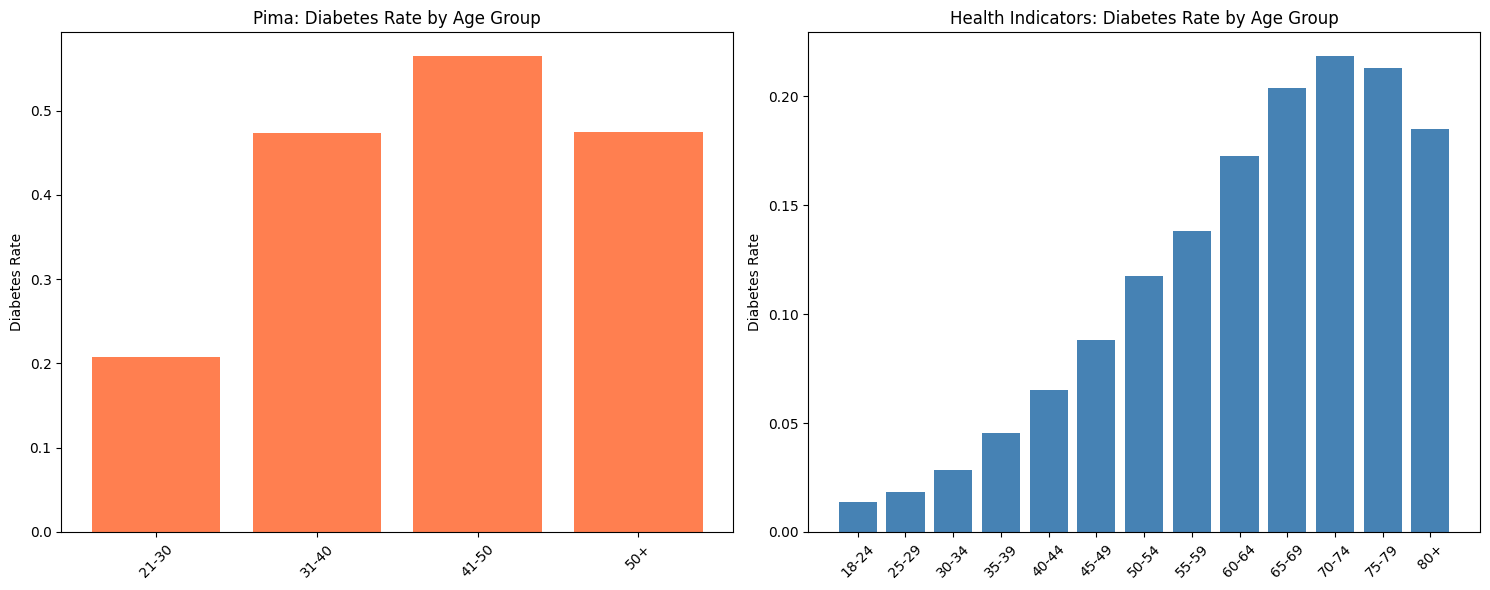

In [14]:
# Side-by-side Age comparison (like BMI comparison)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pima
pima_age = df_pima.groupby('Age_Group')['Outcome'].mean()
axes[0].bar(range(len(pima_age)), pima_age.values, color='coral')
axes[0].set_xticks(range(len(pima_age)))
axes[0].set_xticklabels(pima_age.index, rotation=45)
axes[0].set_ylabel('Diabetes Rate')
axes[0].set_title('Pima: Diabetes Rate by Age Group')

# Health Indicators
health_age = df_health.groupby('Age_Group')['Diabetes_binary'].mean()
axes[1].bar(range(len(health_age)), health_age.values, color='steelblue')
axes[1].set_xticks(range(len(health_age)))
axes[1].set_xticklabels(health_age.index, rotation=45)
axes[1].set_ylabel('Diabetes Rate')
axes[1].set_title('Health Indicators: Diabetes Rate by Age Group')

plt.tight_layout()
plt.savefig('Figures/cross_dataset_age_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# ============================================
# MISSING VALUES FOR SECTION 3
# ============================================

# 1. BRFSS 2015 Diabetes Rate (for Section 3.3.1)
survey_rate = df_health['Diabetes_binary'].mean()
print(f"BRFSS 2015 Survey Diabetes Rate: {survey_rate:.1%}")

# 2. Obesity prevalence in Health Indicators
obesity_rate = (df_health['BMI'] >= 30).mean()
print(f"\nObesity rate (BMI >= 30): {obesity_rate:.1%}")

# 3. Behavioral Risk Score >= 2
high_behavioral_risk = (df_health['Behavioral_Risk_Score'] >= 2).mean()
print(f"Behavioral Risk Score >= 2: {high_behavioral_risk:.1%}")

# 4. Physical inactivity rate
inactivity_rate = (df_health['PhysActivity'] == 0).mean()
print(f"Physical inactivity: {inactivity_rate:.1%}")

# 5. Multiple comorbidities
comorbidities = ((df_health['HighBP'] == 1) & (df_health['HighChol'] == 1)).mean()
print(f"High BP + High Cholesterol: {comorbidities:.1%}")

# 6. Pakistan 2011 and 2024 values
print("\n=== TOP 3 COUNTRIES TABLE ===")
pakistan = df_global[df_global['Entity'] == 'Pakistan'].iloc[0]
samoa = df_global[df_global['Entity'] == 'Samoa'].iloc[0]
fp = df_global[df_global['Entity'] == 'French Polynesia'].iloc[0]

print(f"Pakistan: 2011={pakistan['2011']:.1f}%, 2024={pakistan['2024']:.1f}%, Change=+{pakistan['Prevalence_Change']:.1f}pp")
print(f"Samoa: 2011={samoa['2011']:.1f}%, 2024={samoa['2024']:.1f}%, Change=+{samoa['Prevalence_Change']:.1f}pp")
print(f"French Polynesia: 2011={fp['2011']:.1f}%, 2024={fp['2024']:.1f}%, Change=+{fp['Prevalence_Change']:.1f}pp")

BRFSS 2015 Survey Diabetes Rate: 13.9%

Obesity rate (BMI >= 30): 34.6%
Behavioral Risk Score >= 2: 20.9%
Physical inactivity: 24.3%
High BP + High Cholesterol: 25.5%

=== TOP 3 COUNTRIES TABLE ===
Pakistan: 2011=7.9%, 2024=31.4%, Change=+23.5pp
Samoa: 2011=7.7%, 2024=25.4%, Change=+17.7pp
French Polynesia: 2011=8.6%, 2024=22.8%, Change=+14.2pp
